# Table of contents
1. [Exploring Data](#ExploringData)
    1. [Sex, class and age](#SexClassAge)
2. [Model](#Model)


In [121]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.base import TransformerMixin
from sklearn_pandas import DataFrameMapper
import seaborn as sns
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [122]:
train = pd.read_csv('train.csv')#.drop('PassengerId', axis=1)
test = pd.read_csv('test.csv')#.drop('PassengerId', axis=1)
alldata = pd.concat([train.drop('Survived', axis=1),test])

<a name="ExploringData"></a>
# Exploring Data

In [123]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [94]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


**PassengerId** - irrelevant in terms of features (already dropped)<br>
**Survived** - "1" if survived, "0" otherwise <br>
**Pclass** - one of three classes (1,2,3) <br>
**Name** - name of a passenger including their titles<br>
**Sex** - male or female<br>
**Age** - age in years <br>
**SibSp** - number of passenger's siblings and spauses travelling with them<br>
**Parch** - number of passenger's parents and children travelling with them<br>
**Ticket** - ticket number<br>
**Fare** - fare<br>
**Cabin** - letters encode deck number and numbers encode cabin number <br>

**Missing Data:** <br>
'Age': 263 missing samples<br>
'Cabin': 1014 missing samples (almost 80% of data missing!)<br>
'Emarked': only 2 missing samples

**Intuition**<br>
Sex, Pclass, Fare and Age may play an important role in classification.<br>
Cabin, and even more the deck encoded in this feature may be a very important factor. There are planty of samples missing though.<br>
Noble title which can be extracted from Name can be a good feature.


<a name="SexClassAge"></a>
## Sex, class and age

In [124]:
train.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

/home/piotr/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


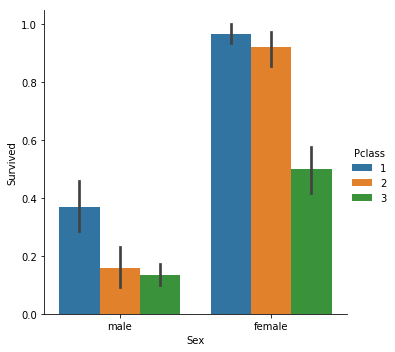

In [96]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train);

/home/piotr/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


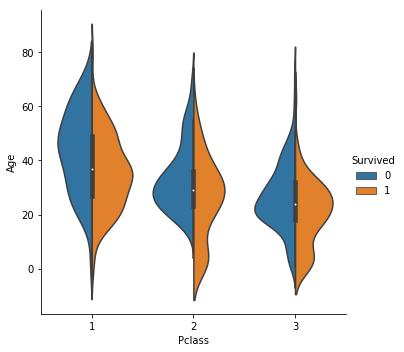

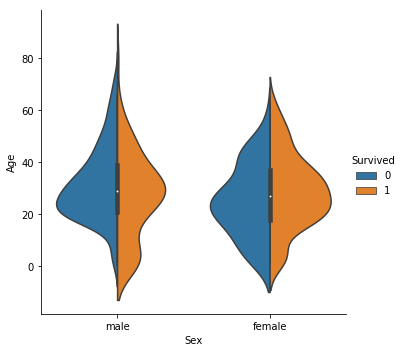

In [97]:
sns.catplot(x="Pclass", y="Age", hue="Survived",
            kind="violin", split=True, data=train)
sns.catplot(x="Sex", y="Age", hue="Survived",
            kind="violin", split=True, data=train);

## Embarked 

/home/piotr/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


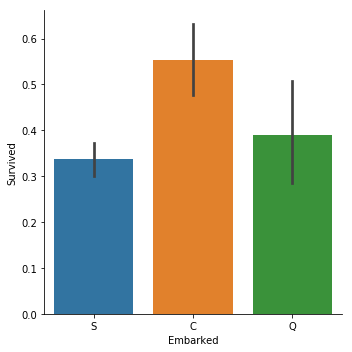

In [98]:
sns.catplot(x="Embarked", y="Survived", kind="bar", data=train);

In [99]:
train.groupby(['Embarked', 'Pclass','Sex']).PassengerId.count()

Embarked  Pclass  Sex   
C         1       female     43
                  male       42
          2       female      7
                  male       10
          3       female     23
                  male       43
Q         1       female      1
                  male        1
          2       female      2
                  male        1
          3       female     33
                  male       39
S         1       female     48
                  male       79
          2       female     67
                  male       97
          3       female     88
                  male      265
Name: PassengerId, dtype: int64

'Embarked' although seems to be a good descriptor is in fact a result of strong correlation with Sex and Pclass. Embarking from Southampton (S) gives us the worst odds for survival. However the reason for that is probably being a male in 3rd class. Of course it could be the other way round, that it is the place of embarkment that somehow affects your chances of survival. This explanation seems nonintuitive though. 

## Title Encoding 

Name is determied for each sample. We can use it to extract all the noble titles  

In [100]:
set([i.split(', ')[1].split('.')[0] for i in alldata['Name']])

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [101]:
class TitleEncoder(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        transformed = X.copy()
        for i in range(len(X)):
            transformed[i] = X[i].split(',')[1].split('.')[0]
        return transformed

class DeckEncoder(TransformerMixin):
    def fit(self,X, y=None):
        return self
    def transform(self, X):
        transformed = X.copy()
        for i in range(len(X)):
            try:
                transformed[i] = X[i][0]
            except TypeError:
                transformed[i] = ' '
        return transformed
    
class SeriesImputer(Imputer):
    def fit(self, X, y=None):
        return super(SeriesImputer, self).fit(np.reshape(X.values,(-1, 1)), y=y)

    def transform(self, X):
        return super(SeriesImputer, self).transform(np.reshape(X.values,(-1, 1)))

## Ticket Encoding

In [102]:
mapper = DataFrameMapper([
    #features
    ('Pclass', sklearn.preprocessing.LabelBinarizer()),
    ('Sex', sklearn.preprocessing.LabelBinarizer()),
    ('Name', [TitleEncoder(),sklearn.preprocessing.LabelBinarizer()],{'alias': 'title'}),
    ('Cabin', [DeckEncoder(),sklearn.preprocessing.LabelBinarizer()],{'alias': 'Deck'}),
    ('Fare', SeriesImputer()),
    ('Age', SeriesImputer()),
    ('SibSp', None),
    ('Parch', None),
    #result
    #('Survived', None)
], input_df=True, df_out=True)

In [103]:
data = mapper.fit_transform(train, train.Survived)

In [104]:
X = np.array(data.values, dtype='float')
y = np.array(train['Survived'].values, dtype='float')

<a name="Model"></a>
# Model

In [114]:
param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
clf_forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf_forest, param_grid=param_grid, cv= 5, scoring='accuracy',n_jobs= 4)
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100, 300], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [115]:
print(grid_search.best_params_)
clf_forest = RandomForestClassifier(**grid_search.best_params_)
scores = cross_val_score(clf_forest, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
[0.8        0.81111111 0.73033708 0.87640449 0.8988764  0.85393258
 0.85393258 0.79775281 0.87640449 0.85227273]
Accuracy: 0.84 (+/- 0.10)


# Submit

In [116]:
test_data = mapper.transform(test)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 34 columns):
Pclass_1               418 non-null int64
Pclass_2               418 non-null int64
Pclass_3               418 non-null int64
Sex                    418 non-null int64
title_ Capt            418 non-null int64
title_ Col             418 non-null int64
title_ Don             418 non-null int64
title_ Dr              418 non-null int64
title_ Jonkheer        418 non-null int64
title_ Lady            418 non-null int64
title_ Major           418 non-null int64
title_ Master          418 non-null int64
title_ Miss            418 non-null int64
title_ Mlle            418 non-null int64
title_ Mme             418 non-null int64
title_ Mr              418 non-null int64
title_ Mrs             418 non-null int64
title_ Ms              418 non-null int64
title_ Rev             418 non-null int64
title_ Sir             418 non-null int64
title_ the Countess    418 non-null int64
Deck_        

In [117]:
X_test = np.array(test_data.values, dtype='float')

In [118]:
clf_forest.fit(X,y)
predictions = clf_forest.predict(X_test).astype(int)

In [119]:
submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

In [120]:
filename = 'Titanic Predictions 1.csv'

submission.to_csv(filename,index=False)